# Test on GSBG2

In [1]:
import numpy

In [2]:
import sklearn

In [3]:
import survwrap

In [4]:
survwrap.list_available_datasets()

('flchain', 'gbsg2', 'metabric', 'support')

In [5]:
mb_df = survwrap.get_data('gbsg2')
mb_df.dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3668 entries, 0 to 685
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     3668 non-null   int64  
 1   meno    3668 non-null   int64  
 2   size    3668 non-null   int64  
 3   grade   3668 non-null   int64  
 4   nodes   3668 non-null   int64  
 5   pgr     3668 non-null   int64  
 6   er      3668 non-null   int64  
 7   hormon  3668 non-null   int64  
 8   time    3668 non-null   float64
 9   event   3668 non-null   int64  
dtypes: float64(1), int64(9)
memory usage: 315.2 KB


In [6]:
X, y = mb_df.get_X_y()
X.shape, y.shape

((3668, 8), (3668,))

In [7]:
y[680:690]

array([(False, 2921.00006199), (False, 1938.99997735),
       (False, 3018.00008678), (False, 3445.0000906 ),
       (False, 1874.9999969 ), (False, 3322.99998999),
       (False, 4215.00019646), (False, 2261.00010395),
       (False, 4374.00009346), (False, 2903.9999547 )],
      dtype=[('event', '?'), ('time', '<f8')])

### Generate a (stratified) train-test split and Scale the features (only) 

First do the stratified splitting THEN do scaling, parameterized on X_train set ONLY 

In [8]:
from sklearn.preprocessing import StandardScaler, RobustScaler

In [9]:
X_train, X_test, y_train, y_test = survwrap.survival_train_test_split(X, y, rng_seed=2309)

In [10]:
scaler = RobustScaler().fit(X_train)
[X_train, X_test] = [ scaler.transform(_) for _ in  [X_train, X_test] ]
X_train.shape, X_test.shape

((2751, 8), (917, 8))

In [11]:
survwrap.get_indicator(y).sum(), survwrap.get_indicator(y_train).sum(), survwrap.get_indicator(y_test).sum(),


(1817, 1363, 454)

## check possible dimensionality reduction

In [12]:
from sklearn.decomposition import PCA

In [13]:
pca= PCA(n_components=0.995, random_state=2308).fit(X_train)
print('PCA components:',pca.n_components_)

PCA components: 8


In [14]:
## Stratified CV spliter for survival analysis

In [15]:
#from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold

In [16]:
#testkf= RepeatedStratifiedKFold(n_splits=5,n_repeats=2,random_state=2307)
#for trn,tst in testkf.split(X_train, survwrap.get_indicator(y_train)):
#    print(trn,tst) 

# test coxnet

In [17]:
coxnet = survwrap.CoxNet(rng_seed=2309)
coxnet.fit(X_train, y_train)

CoxNet(rng_seed=2309, l1_ratio=0.5, verbose=False, fit_baseline_model=False)

In [18]:
coxnet.score(X_test, y_test)

0.6887912277300243

In [19]:
#from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [20]:
coxnet.get_parameter_grid()

{'l1_ratio': [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]}

In [21]:
opt_coxnet, opt_coxnet_params, opt_coxnet_search = survwrap.optimize(coxnet, X_train, y_train,  n_jobs=4)
opt_coxnet.score(X_test, y_test), opt_coxnet_params

(0.6894590577134363, {'l1_ratio': 0.01})

In [22]:
survwrap.get_top_models(opt_coxnet_search)

[(1, 0.6694876341728885, 0.01305643245602949, {'l1_ratio': 0.01}),
 (2, 0.6694018828807328, 0.013022090822348342, {'l1_ratio': 0.1}),
 (3, 0.6692828007193661, 0.012889705044678621, {'l1_ratio': 0.25}),
 (4, 0.6692613821092743, 0.012799356641076627, {'l1_ratio': 0.5}),
 (5, 0.66922694942408, 0.012796312712512957, {'l1_ratio': 0.9}),
 (6, 0.6692229583770107, 0.012781217883428212, {'l1_ratio': 0.99}),
 (7, 0.6692220816702286, 0.01281013923941198, {'l1_ratio': 0.75})]

# Test DSM

In [23]:
batch5 = int(X_train.shape[0] /20 ) 

In [24]:
fl_dsm=survwrap.DeepSurvivalMachines(rng_seed=2309, batch_size=batch5, layer_sizes=[8], validation_size=0.2, 
                                     learning_rate=0.01, max_epochs=100, n_distr=2, elbo=True, distr_kind='Weibull')
fl_dsm

DeepSurvivalMachines(rng_seed=2309, n_distr=2, distr_kind='Weibull', batch_size=137, layer_sizes=[8], learning_rate=0.01, validation_size=0.2, max_epochs=100, elbo=True)

In [25]:
#fl_dsm.layer_sizes=[3]
#fl_dsm.learning_rate=0.01
fl_dsm_xplore=fl_dsm.fit(X_train,y_train)
fl_dsm_xplore
#fl_dsm_xplore.score(X_train,y_train)

fl_dsm_xplore.score(X_train,y_train), fl_dsm_xplore.score(X_test,y_test)

 24%|██████████████████████████████▉                                                                                                  | 24/100 [00:00<00:03, 25.13it/s]


(0.68429523863456, 0.7045893563698773)

In [26]:
grid =survwrap.DeepSurvivalMachines.get_parameter_grid(max_width=X_train.shape[1])
grid

{'n_distr': [1, 2, 3],
 'distr_kind': ['Weibull'],
 'batch_size': [16, 32],
 'layer_sizes': [[3],
  [4],
  [5],
  [7],
  [3, 3],
  [4, 4],
  [5, 5],
  [7, 7],
  [3, 3, 3],
  [4, 4, 4],
  [5, 5, 5],
  [7, 7, 7]],
 'learning_rate': [0.005, 0.001],
 'validation_size': [0.1],
 'max_epochs': [100],
 'elbo': [False]}

In [27]:
# Stratified CV
#opt_dsm, opt_dsm_params, opt_dsm_search = optimize(survwrap.DeepSurvivalMachines(rng_seed=2308),  X_train, y_train, n_jobs=8,
                                                  # user_grid=grid,cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=2308).split(X_train,survwrap.get_indicator(y_train)))
#opt_dsm.score(X_test, y_test), opt_dsm_params

In [28]:
# Stratified CV
fl_dsm=survwrap.DeepSurvivalMachines(rng_seed=2309,max_epochs=200, validation_size=0.2, batch_size=batch5)
fl_grid=fl_dsm.get_parameter_grid(max_width=3)
fl_grid['batch_size']=[batch5]
fl_grid['n_distr']=[2]
fl_grid

{'n_distr': [2],
 'distr_kind': ['Weibull'],
 'batch_size': [137],
 'layer_sizes': [[3], [3, 3], [3, 3, 3]],
 'learning_rate': [0.005, 0.001],
 'validation_size': [0.1],
 'max_epochs': [100],
 'elbo': [False]}

In [29]:
opt_dsm, opt_dsm_params, opt_dsm_search = survwrap.optimize(fl_dsm,  X_train, y_train, user_grid=fl_grid, n_jobs=4)
opt_dsm.score(X_test, y_test), opt_dsm_params

 15%|███████████████████▎                                                                                                             | 15/100 [00:00<00:04, 21.12it/s]


(0.6890407663528584,
 {'batch_size': 137,
  'distr_kind': 'Weibull',
  'elbo': False,
  'layer_sizes': [3, 3],
  'learning_rate': 0.005,
  'max_epochs': 100,
  'n_distr': 2,
  'validation_size': 0.1})

In [30]:
survwrap.get_top_models(opt_dsm_search)

[(1,
  0.6638592543789789,
  0.017563736522538106,
  {'batch_size': 137,
   'distr_kind': 'Weibull',
   'elbo': False,
   'layer_sizes': [3, 3],
   'learning_rate': 0.005,
   'max_epochs': 100,
   'n_distr': 2,
   'validation_size': 0.1}),
 (2,
  0.6618388212026807,
  0.01680284757554033,
  {'batch_size': 137,
   'distr_kind': 'Weibull',
   'elbo': False,
   'layer_sizes': [3],
   'learning_rate': 0.005,
   'max_epochs': 100,
   'n_distr': 2,
   'validation_size': 0.1}),
 (3,
  0.6604066822945046,
  0.018080381213841295,
  {'batch_size': 137,
   'distr_kind': 'Weibull',
   'elbo': False,
   'layer_sizes': [3, 3, 3],
   'learning_rate': 0.005,
   'max_epochs': 100,
   'n_distr': 2,
   'validation_size': 0.1}),
 (4,
  0.659515767838107,
  0.01887316527061439,
  {'batch_size': 137,
   'distr_kind': 'Weibull',
   'elbo': False,
   'layer_sizes': [3, 3, 3],
   'learning_rate': 0.001,
   'max_epochs': 100,
   'n_distr': 2,
   'validation_size': 0.1}),
 (5,
  0.6586663367352833,
  0.019350780

# PyCox

In [31]:
#import pycox.models

In [39]:
fl_dhs = survwrap.DeepHitSingle(rng_seed=2309)
fl_dhs

DeepHitSingle(rng_seed=2309, num_durations=10, layer_sizes=[10, 10], epochs=10, batch_size=16, validation_size=0.1, learning_rate=0.001, dropout=0.1, device='cpu')

In [37]:
dhs_grid = fl_dhs.get_parameter_grid(max_width=8)
dhs_grid['batch_size']=[batch5]
dhs_grid['dropout']=[0.2]
dhs_grid

{'num_durations': [10],
 'layer_sizes': [[3],
  [4],
  [5],
  [7],
  [3, 3],
  [4, 4],
  [5, 5],
  [7, 7],
  [3, 3, 3],
  [4, 4, 4],
  [5, 5, 5],
  [7, 7, 7]],
 'epochs': [100],
 'batch_size': [137],
 'dropout': [0.2],
 'validation_size': [0.1]}

In [40]:
opt_dhs, opt_dhs_params, opt_dhs_search = survwrap.optimize(fl_dhs,  X_train, y_train, user_grid=dhs_grid, n_jobs=1)
opt_dhs.score(X_test, y_test), opt_dhs_params

(0.6913440616988733,
 {'batch_size': 137,
  'dropout': 0.2,
  'epochs': 100,
  'layer_sizes': [3],
  'num_durations': 10,
  'validation_size': 0.1})

In [41]:
survwrap.get_top_models(opt_dhs_search)

[(1,
  0.6750846918469555,
  0.018500384343510572,
  {'batch_size': 137,
   'dropout': 0.2,
   'epochs': 100,
   'layer_sizes': [3],
   'num_durations': 10,
   'validation_size': 0.1}),
 (2,
  0.6707956614299107,
  0.015879720814370737,
  {'batch_size': 137,
   'dropout': 0.2,
   'epochs': 100,
   'layer_sizes': [4],
   'num_durations': 10,
   'validation_size': 0.1}),
 (3,
  0.6656579088034458,
  0.013299489503216015,
  {'batch_size': 137,
   'dropout': 0.2,
   'epochs': 100,
   'layer_sizes': [4, 4],
   'num_durations': 10,
   'validation_size': 0.1}),
 (4,
  0.6651048980728758,
  0.018823535052887946,
  {'batch_size': 137,
   'dropout': 0.2,
   'epochs': 100,
   'layer_sizes': [7],
   'num_durations': 10,
   'validation_size': 0.1}),
 (5,
  0.6629710044231338,
  0.014029048247762174,
  {'batch_size': 137,
   'dropout': 0.2,
   'epochs': 100,
   'layer_sizes': [7, 7, 7],
   'num_durations': 10,
   'validation_size': 0.1}),
 (6,
  0.6551085583594881,
  0.017862666593351718,
  {'batch_

In [44]:
fl_dhs.layer_sizes=[4,4]
fl_dhs.learning_rate=0.02
fl_dhs.batch_size=batch5
fl_dhs_xplore=fl_dhs.fit(X_train,y_train)
fl_dhs_xplore.score(X_train,y_train)

0.6810981042113482

<Axes: >

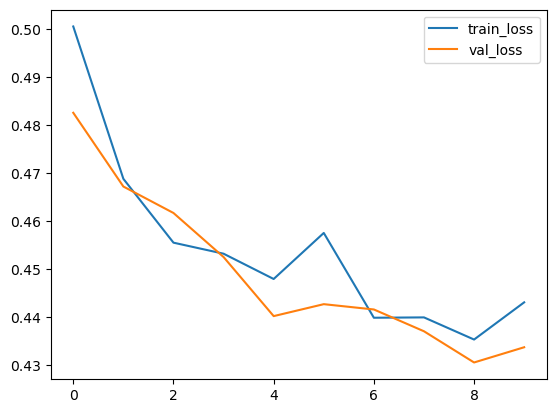

In [45]:
fl_dhs_xplore.training_log_.plot()

In [ ]:
dhs_grid['batch_size']=[batch5]
dhs_grid['dropout']=[0.2]
dhs_grid

In [ ]:
opt__dhs.score(X_test, y_test), opt_dhs_params

In [ ]:
opt__dhs.training_log_.plot()

In [ ]:
survwrap.get_top_models(opt_dhs_search, X_test, y_test)